# Data Analysis and Mining - PCA

## Objectives 
- Perform Principal Component Analysis.
- Perform Single Value Decomposition.

## Initialization

### Import libraries

In [1217]:
import numpy as np
import pandas as pd
import seaborn as sns
import skfuzzy as fuzz
import scipy.spatial

from matplotlib import pyplot as plt

%matplotlib inline
sns.set_style("darkgrid")

### Load data

Start by loading the entire dataset.

In [1218]:
# Specify the path to the dataset CSV file
dataset_path = "../../Dataset/dataset.csv"

# Read the dataset into a pandas DataFrame
df = pd.read_csv(dataset_path)

df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017


### Data cleaning

Then, we drop columns that we do not need. In addition, we add one more column which represents the percentage of win games, as it is one of the most interesting features.

In [1219]:
# Drop columns 'TEAM', 'CONF', 'POSTSEASON', 'SEED'
df = df.drop(['TEAM', 'CONF', 'POSTSEASON', 'SEED'], axis=1)

Check the size of the dataset.

In [1220]:
df.shape

(1757, 20)

We decided to analyze a subset of the whole dataset. Since our dataset is a collection of data which belongs to 5 different seasons, we filter the dataset by only keeping and analyzing the information related to one year.

In [1221]:
# Filter by year, keep only data from selected year
df = df[df['YEAR'] == 2015].drop('YEAR', axis=1)

Check the size of the dataset.

In [1222]:
df.shape

(351, 19)

In [1223]:
# Reset the index
df = df.reset_index(drop=True)

df.head()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
0,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3
1,39,35,125.2,90.6,0.9764,56.6,46.5,16.3,18.6,35.8,30.2,39.8,23.9,55.9,46.3,38.7,31.4,66.4,10.7
2,36,27,109.4,87.4,0.9290,47.7,44.0,17.2,21.3,34.7,30.8,38.7,33.3,48.4,43.3,30.7,30.3,65.6,5.8
3,38,32,125.3,98.6,0.9401,58.3,47.9,14.5,17.3,27.9,32.2,36.7,24.1,58.2,47.4,39.0,32.6,63.9,8.6
4,38,34,117.5,86.9,0.9700,53.5,45.1,16.5,20.6,34.5,22.4,47.1,37.3,53.3,42.7,36.0,33.5,66.7,9.0


### Classification

Set up a list of colours.

In [1224]:
colours = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

And let's center it now.

In [1225]:
# To do PCA, normalize data getting df1 by standard deviation and df2 by min-max
df = (df - df.mean()) / df.std()

## Fuzzy clustering

### Visualization

Preprocess...

In [1226]:
# Get data as numpy array
alldata = df.values

# Set parameters
num_seeds = 20
num_clusters = 5
fuzzyness = 2

# Prepare colors
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Store info in a dictionary which maps to ncenters and seed the matrix of centers m, the list cluster_centers and the last value of jm
info = {}
# And a dictionary which maps to each value of c the best
best = {}

for ncenters in range(2, num_clusters+1):

    for seed in range(num_seeds):

        # Compute fuzzy c-means clustering
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(alldata.T, ncenters, fuzzyness, error=0.005, maxiter=1000, init=None, seed=seed)

        # Assign cluster centers
        cluster_centers = np.argmax(u, axis=0)

        # Init a matrix with ncenters rows and df.columns columns to compute the centroid of each cluster (cntr are wrong)
        m = np.zeros((ncenters, df.shape[1]))

        # Compute centers (cntr are wrong)
        for j in range(ncenters):
            # For each column in the dataset, store the mean for the cluster_centers == j elements (cntr are wrong)
            for i in range(df.shape[1]):
                m[j, i] = df.iloc[cluster_centers == j, i].mean()

        # Store info
        info[ncenters, seed] = (m, cluster_centers, jm[-1], u)

    # Save old info for later
    old_info = info.copy()

    # Only select from info the info related to the seed with minimum jm
    best[ncenters] = info[ncenters, np.argmin([info[ncenters, seed][2] for seed in range(num_seeds)])]

    # Save old info for later
    old_best = best.copy()

Visualize over ADJOE and ADJDE.

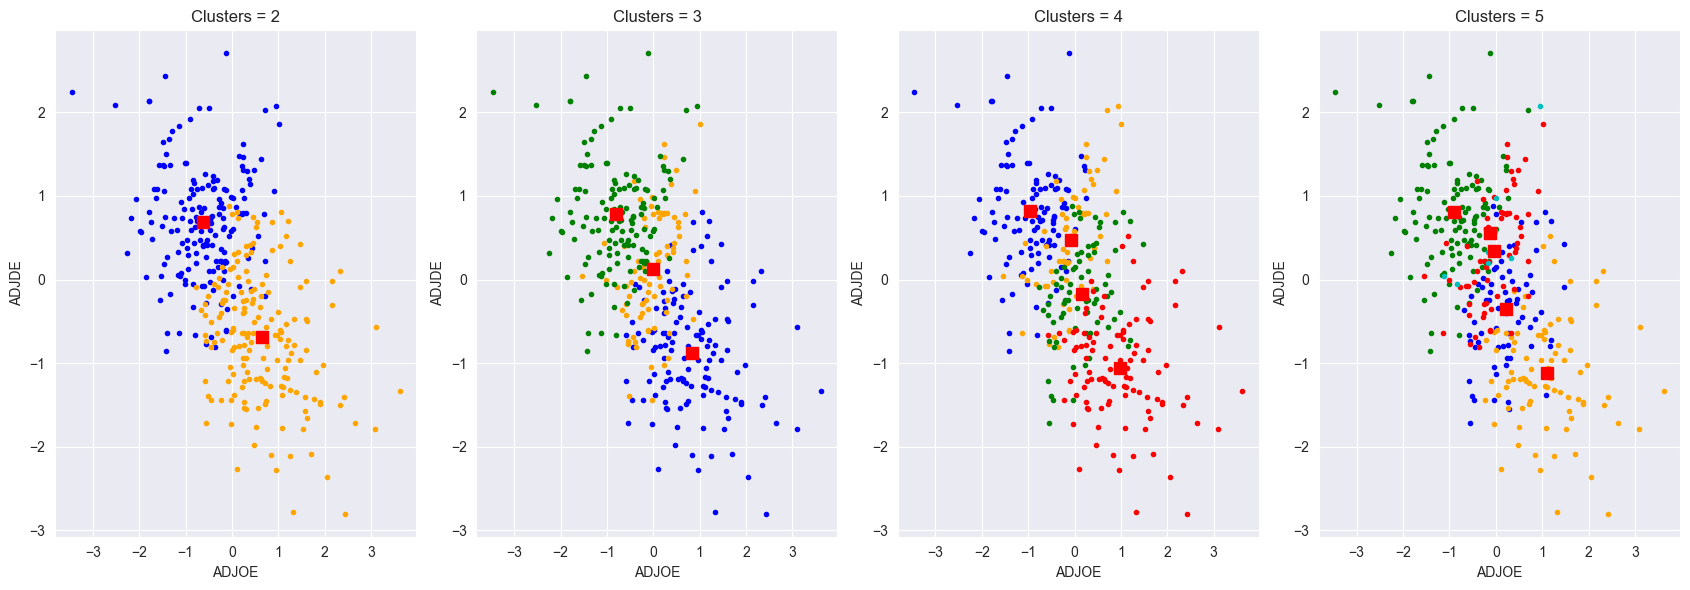

In [1227]:
# One plot for each number of clusters
fig, axes = plt.subplots(1, num_clusters-1, figsize=(17, 6))

for ncenters, ax in enumerate(axes.reshape(-1), 2):

    # Plot data
    for j in range(ncenters):
        # Plot over PC1 and PC2 data such that their cluster_center == j
        ax.plot(df['ADJOE'][best[ncenters][1] == j], df['ADJDE'][best[ncenters][1] == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in best[ncenters][0]:
        ax.plot(pt[2], pt[3], 'rs', markersize=8)

    # Add title to the plot
    ax.set_title('Clusters = {0}'.format(ncenters))
    # Add labels to the plot
    ax.set_xlabel('ADJOE')
    ax.set_ylabel('ADJDE')

fig.tight_layout()

Project data to better features using PCA for visualization...

In [1228]:
# Compute the covariance matrix from df
covmatrix = df.cov()

# Obtain the eigenvalues and eigenvectors from the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covmatrix)

# Sort the eigenvalues in descending order
idxs = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idxs]
eigenvectors = eigenvectors[:,idxs]

# Obtain principal components (data in the new space)
pc = np.dot(df, eigenvectors)

# Make pc a dataframe
names = ["PC"+str(x+1) for x in range(pc.shape[1])]
df_pc = pd.DataFrame(data = pc, columns = names)

Visualize over PC1 and PC2.

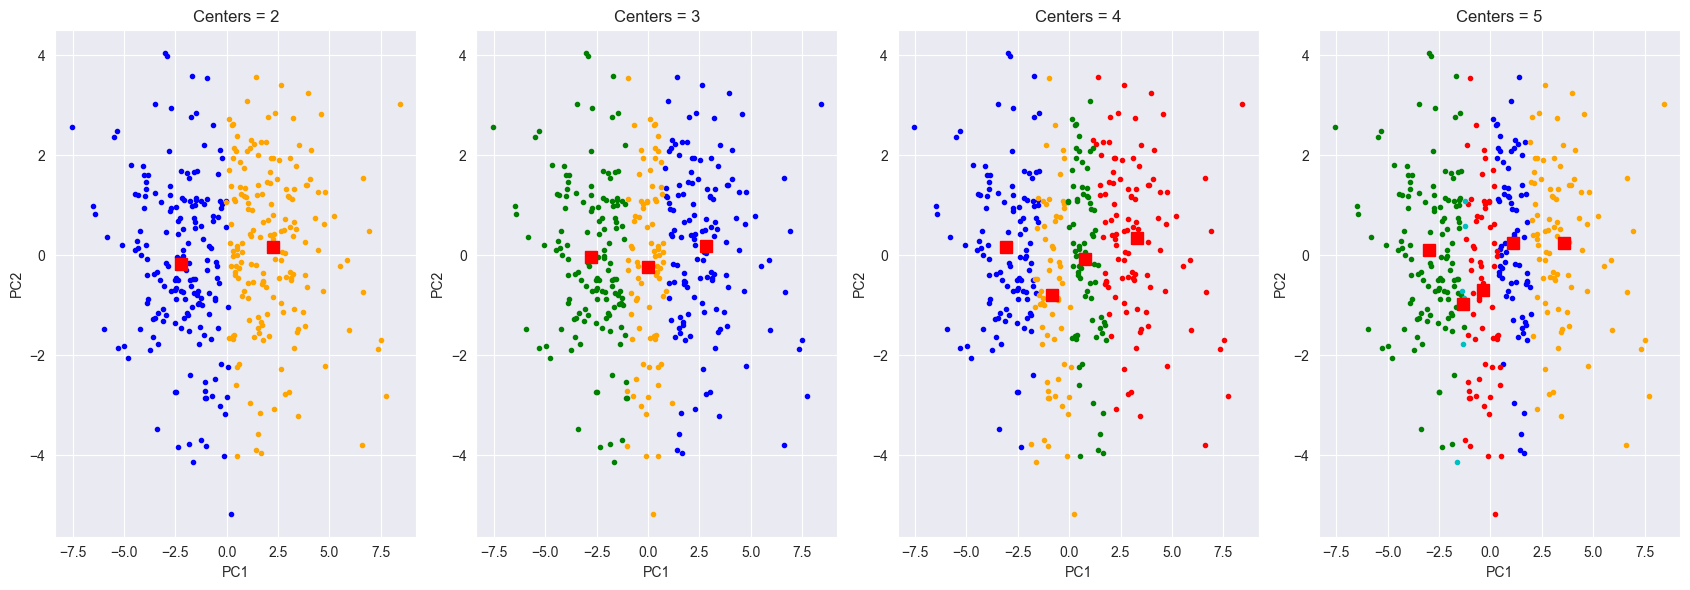

In [1229]:
# Set up the loop and plot
fig, axes = plt.subplots(1, num_clusters-1, figsize=(17, 6))

for ncenters, ax in enumerate(axes.reshape(-1), 2):
    
    # Plot data
    for j in range(ncenters):
        # Plot over PC1 and PC2 data such that their cluster_center == j
        ax.plot(df_pc['PC1'][best[ncenters][1] == j], df_pc['PC2'][best[ncenters][1] == j], '.', color=colors[j])

    # Compute the centers in the new space
    m = np.dot(best[ncenters][0], eigenvectors)
    # Mark the center of each fuzzy cluster
    for pt in m:
        ax.plot(pt[0], pt[1], 'rs', markersize=8)

    # Add title to the plot
    ax.set_title('Centers = {0}'.format(ncenters))
    # Add labels to the plot
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

fig.tight_layout()


### Choose the best number of clusters

As the plot below shows, it's pointless to pick the number of clusters which minimizes the cost function.

Text(0, 0.5, 'Cost Function')

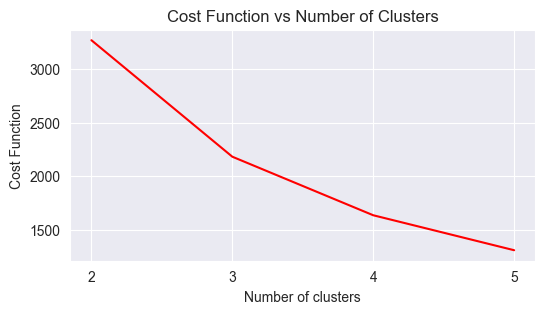

In [1230]:
# Plot the best cost function obtained for each ncenters
plt.figure(figsize=(6, 3))

# Add a line to connect the points
plt.plot(range(2, num_clusters+1), [best[ncenters][2] for ncenters in range(2, num_clusters+1)], 'r-')

# Only show integers in the x-axis
plt.xticks(range(2, num_clusters+1))

plt.title('Cost Function vs Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Cost Function')

Thus, let's see if any number of clusters is stable.

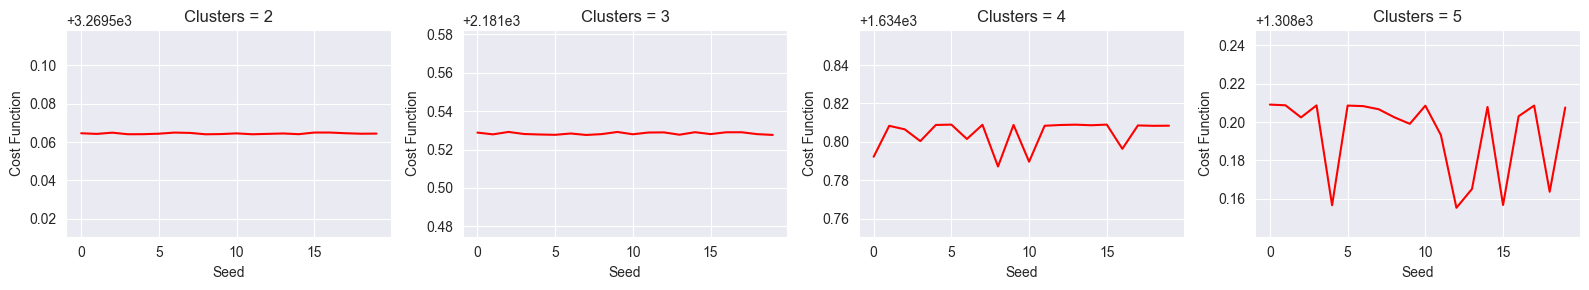

In [1231]:
# Make one plot for each value of ncenters
fig, axes = plt.subplots(1, num_clusters-1, figsize=(16, 3))

# Compute avg cost function for each cluster
avg = {}

# Compute max difference between the max and min cost function values for each cluster
diff = 0

# Plot the cost function for each seed
for ncenters in range(2, num_clusters+1):

    # Plot the line
    axes[ncenters-2].plot(range(num_seeds), [info[ncenters, seed][2] for seed in range(num_seeds)], 'r-')
    # Add title to the plot
    axes[ncenters-2].set_title('Clusters = {0}'.format(ncenters))
    # Add labels to the plot
    axes[ncenters-2].set_xlabel('Seed')
    axes[ncenters-2].set_ylabel('Cost Function')

    # Compute the max difference between the cost function values for each cluster, and the average cost function for each
    min = np.inf
    max = -np.inf
    avg[ncenters] = 0
    for seed in range(num_seeds):
        avg[ncenters] += info[ncenters, seed][2]
        if info[ncenters, seed][2] > max:
            max = info[ncenters, seed][2]
        if info[ncenters, seed][2] < min:
            min = info[ncenters, seed][2]
    avg[ncenters] /= num_seeds
    if diff < max - min:
        diff = max - min

# Save old info for later
old_diff = diff
old_avg = avg.copy()

for ncenters in range(2, num_clusters+1):
    axes[ncenters-2].set_ylim(avg[ncenters]-diff, avg[ncenters]+diff)

fig.tight_layout()


Let's plot the membership values for each cluster...

CHECK THE TITLES OF THE PLOTS AND THEIR ORDER, I ASSIGNED MANUALLY


Text(0.5, 1.0, 'Good team')

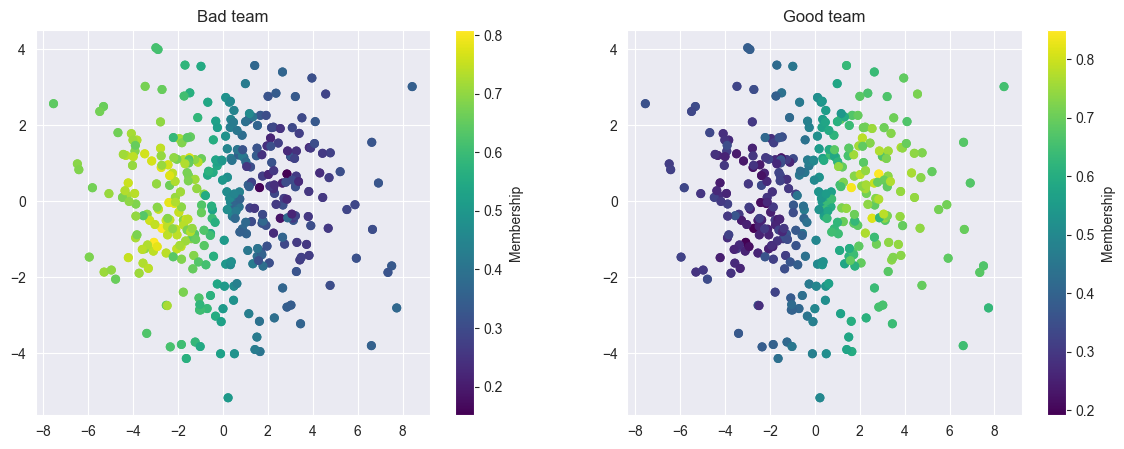

In [1232]:
# Assuming the best number of clusters is 2
n = 2

fig, axes = plt.subplots(1, n, figsize=(14, 5))
for cluster_num, ax in enumerate(axes.reshape(-1)):
    ax.scatter(df_pc['PC1'], df_pc['PC2'], c=best[n][3][cluster_num], cmap='viridis', s=30)
    # Add colorbar
    cbar = plt.colorbar(ax.scatter(df_pc['PC1'], df_pc['PC2'], c=best[n][3][cluster_num], cmap='viridis', s=30), ax=ax)
    cbar.set_label('Membership')
    ax.grid(True)

# Add titles to the first and second subplots
print("CHECK THE TITLES OF THE PLOTS AND THEIR ORDER, I ASSIGNED MANUALLY")
axes[0].set_title('Bad team')
axes[1].set_title('Good team')

CHECK THE TITLES OF THE PLOTS AND THEIR ORDER, I ASSIGNED MANUALLY


Text(0.5, 1.0, 'Bad team')

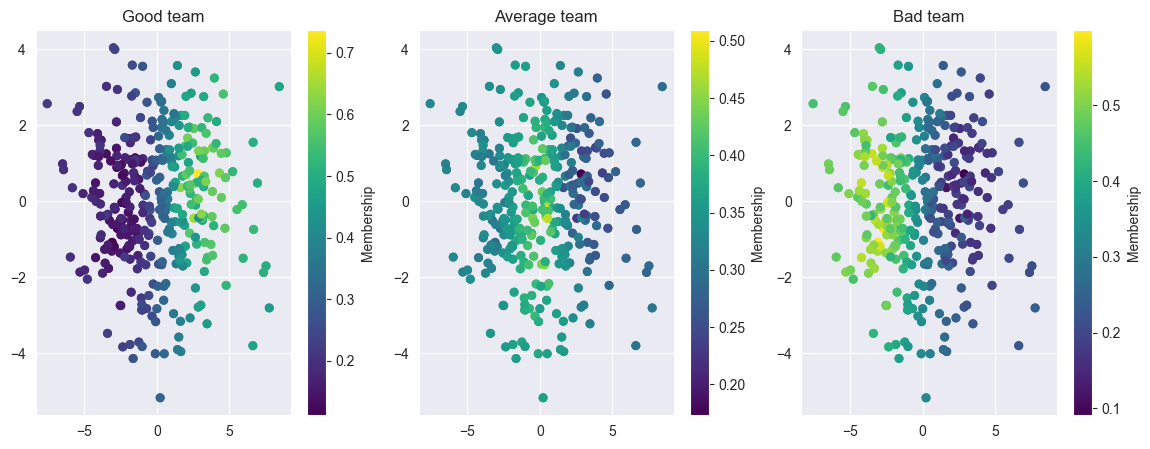

In [1233]:
# Assuming the best number of clusters is 3
n = 3

fig, axes = plt.subplots(1, n, figsize=(14, 5))
for cluster_num, ax in enumerate(axes.reshape(-1)):
    ax.scatter(df_pc['PC1'], df_pc['PC2'], c=best[n][3][cluster_num], cmap='viridis', s=30)
    # Add colorbar
    cbar = plt.colorbar(ax.scatter(df_pc['PC1'], df_pc['PC2'], c=best[n][3][cluster_num], cmap='viridis', s=30), ax=ax)
    cbar.set_label('Membership')
    ax.grid(True)

# Add titles to the first and second subplots
print("CHECK THE TITLES OF THE PLOTS AND THEIR ORDER, I ASSIGNED MANUALLY")
axes[0].set_title('Good team')
axes[1].set_title('Average team')
axes[2].set_title('Bad team')

## Iterative Anomalous Pattern Clustering

### Define functions

In [1234]:
def center_(x, c):
    """ 
    x - the original data matrix (N x d)
    c - the set with indices (i= 1, 2, ..., N) of the objects belonging to the cluster
    returns the centroid of the cluster 
    """
    #number of columns
    mm = x.shape[1]
    centroidC = []
    
    for j in range(mm):
        zz = x[:, j]
        zc = []
        for i in c:
            zc.append(zz[i])
        centroidC.append(np.mean(zc))
    return centroidC

def distNorm(x, remains, ranges, p):
    """ 
     Finds normalized (by range) distances (euclidean) of data point in 'remains' from reference point 'p' 
     x - the original data matrix (N x mm)
     remains - the set of rr X-row indices of the entities under consideration
     ranges - the vector with the ranges max-min of the features  
     p - the reference data point the distances relate to
     distan - returns the column vetor  with the distances from p to remains 
     """
    
    mm = x.shape[1]         # number of data features (mm)
    rr = len(remains)       # number of entities in remains (rr)

    z = x[remains, :]       # subset of data with rr remains entities (rr x mm)

    az = np.tile(np.array(p), (rr, 1))      # matrix constructed by repeating the reference point p rr times (rr x mm)
    
    rz = np.tile(np.array(ranges), (rr, 1))     # matrix constructed by repeating the list ranges rr times (rr x mm)

    dz = np.array( (z - az) / rz )      # normalized differences between the features of the data points in z and the features of p (rr x mm)
    ddz = dz * dz                       # squared differences (rr x mm)

    if mm > 1:                  # sum of squared differences for each data point, that are the distances (rr x 1)
        di = sum(ddz.T)         
    else:
        di = ddz.T

    return np.sqrt(di)          # returns the column vector with the distances from p to remains (rr x 1)

def separCluster(x0, remains, ranges, a, b):

    """  
    Builds a cluster by splitting the points around the reference point 'a' from those around the reference point b 
    x0 - data matrix
    remains - the set of X-row entities under consideration
    ranges -  the vector with the ranges of the data features  
    a, b - the reference points
    cluster - returns a set with X-row indices of the objects belonging to the cluster with the reference point 'a'
    """
    
    dista = distNorm(x0, remains, ranges, a)
    distb = distNorm(x0, remains, ranges, b)

    clus = np.where(dista < distb)[0]       # get X-row indices of the objects closer to a than to b
    cluster = []
    for i in clus:                          # form cluster of a
        cluster.append(remains[i])

    return cluster                          # returns the subset of x0 rows that are closer to a than to b


 ## Consult description of building an Anomalous cluster (lecture T3 - slide #57)

def anomalousPattern(x, remains, ranges, centroid, me):
    """
    Builds one anomalous cluster based on the algorithm 'Separate/Conquer' (B. Mirkin (1999): Machine Learning Journal) 
    x0 - data matrix
    remains - the set of X-row indices of the entities under consideration
    ranges - vector with max-min ranges of data features  
    centroid - initial center of the anomalous cluster being built
    me - vector to shift the 0 (origin) to
    Returns a tuple with:
        cluster - subset of remains row indices in the anomalous cluster, 
        centroid - center of the built anomalous cluster    
    """        
    key = 1
    while key == 1:

        cluster = separCluster(x, remains, ranges, centroid, me)    # build a cluster around the anomalous centroid
        if len(cluster) != 0:                                       # if the cluster is not empty
            newcenter = center_(x, cluster)                         # find the center of the anomalous cluster
          
        if  len([i for i, j in zip(centroid, newcenter) if i == j]) != len(centroid):   # zip function just to compare the two lists
            centroid = newcenter                                                        # and if there's any difference in the centroid (if the centroid changed)
                                                                                        # update the centroid                       
        else:
            key = 0

    return (cluster, centroid)

### Run IAP

Execute the algorithm for some values of threshold.

In [1235]:
normalized = True       # normalization FLAG whether already normalized or not

x = df_pc.values.astype(np.float32)         # take matrix from normalized dataframe containing the PCA data

nn = x.shape[0]         # number of data points
mm = x.shape[1]         #number of features

mmax = []       # maximum values of features
mmin = []       # minimum values of features
me = []         # mean values of features
ranges = []     # max.min range of features
ancl = []       # "anomalous cluster" ancl is the data structure to keep everything together

for j in range(mm):             # for each feature
    z = x[:, j]                 # data column vector j-th feature

    mmax.append(np.max(z))                      # maximum of the j-th feature
    mmin.append(np.min(z))                      # minimum of the j-th feature
    me.append(np.mean(z))                       # mean of the j-th feature
    if normalized:                              # ranges of the j-th feature
        ranges.append(1)
    else:
        ranges.append(mmax[j] - mmin[j])
    if ranges[j] == 0:                          # if the range is 0 (constant variable), set it to 1
        ranges[j] = 1
    
sY = np.array(np.divide((x - me), ranges))      # standardised data matrix
d = np.sum(sY * sY)                             # Square Sum of data matrix

remains = list(range(nn))               # init remains with all data points
numberC = 0;                            # counter of anomalous clusters 
while( len(remains) != 0 ):
    distances = distNorm(x, remains, ranges, me)        # finding normalised distance vector from remains data points to reference 'me'
                                                        # that is the origin if data was standardised already
    index = remains[np.argmax(distances)]               # index of the data point with the highest distance
    centroid = x[index, :]                              # initial anomalous center reference point: the one with higher distance
    numberC = numberC + 1                               # found a new cluster
    
    (cluster, centroid) = anomalousPattern(x, remains, ranges, centroid, me) # finding AP cluster around the centroid
    
    censtand = np.divide((np.asarray(centroid) - me), np.asarray(ranges))           # standardised centroid 
    dD = np.sum(np.divide(censtand * censtand.T * len(cluster) * 100, d))           # cluster contribution (per cent) - (lecture T3 - slide #61 of K-means)

    remains = np.setdiff1d(remains, cluster)            # find remains by removing the cluster from the remains

    ancl.append([cluster, censtand, dD])                # set of data points in the cluster, standardised centroid and proportion of the data scatter

ll = []                                     # list of number of elements of clusters
for ik in range(numberC):
    ll.append(len(ancl[ik][0]))
    
init_partition = {}
prev_num_clusters = np.inf
start = 10
for thre in range(start, 50):              # for each threshold value from 10 to 50
    rl = [i for i in ll if i >= thre]      # list of clusters with at least threshold elements

    cent = []                                 # list of centroids of clusters with at least threshold elements                   
    if len(rl) == 0 :
        print('Too great a threshold!!!')
    else:                                       # if we found at least one decent cluster, we can get the centroids of the clusters with at least threshold elements
        for ik in range(numberC):               # notice: we are just looking for the centroids, to re-assign elements in small clusters (smaller than threshold)
            cluster = ancl[ik][0]
            if len(cluster) >= thre :
                cent.append(ancl[ik][1])        
    cent = np.asarray(cent)
    cent = cent.reshape((len(cent), len(ancl[0][1])))

    init_partition[thre] = np.zeros((df_pc.shape[0], len(cent)))          # get membership matrix (crisp) of the data points to initialize FCM

    for index, d in enumerate(df_pc.values):                        # for each data point
        dists = [np.linalg.norm(d - c) for c in cent]               # find the distance to each centroid
        assign = dists.index(np.min(dists))                         # assign the data point to the closest centroid
        init_partition[thre][index, assign] = 1

    if len(cent) < prev_num_clusters:               # if the number of clusters is the same as in the previous iteration, print it
        print("IAP identified", len(cent), "clusters with threshold of", thre, "elements")
        prev_num_clusters = len(cent)

print("Reminder: the number of elements is ", len(init_partition[thre]) )

IAP identified 6 clusters with threshold of 10 elements
IAP identified 5 clusters with threshold of 15 elements
IAP identified 4 clusters with threshold of 22 elements
IAP identified 3 clusters with threshold of 33 elements
IAP identified 2 clusters with threshold of 38 elements
Reminder: the number of elements is  351


Pick a value and use the result as inizialization to start fuzzy clustering algorithm...

In [1236]:
thresholds = [15, 25, 35, 45]

# Store info in a dictionary which maps to ncenters and seed the matrix of centers m, the list cluster_centers and the last value of jm
info = {}

for threshold in thresholds:
    
    ncenters = len(init_partition[threshold][0])

    # Compute fuzzy c-means clustering with init_partition to start from the IAP
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(alldata.T, ncenters, 2, error=0.005, maxiter=1000, init=init_partition[threshold].T)

    # Assign cluster centers
    cluster_centers = np.argmax(u, axis=0)

    # Init a matrix with ncenters rows and df.columns columns to compute the centroid of each cluster (cntr are wrong)
    m = np.zeros((ncenters, df.shape[1]))

    # Compute centers (cntr are wrong)
    for j in range(ncenters):
        # For each column in the dataset, store the mean for the cluster_centers == j elements (cntr are wrong)
        for i in range(df.shape[1]):
            m[j, i] = df.iloc[cluster_centers == j, i].mean()

    # Store info
    info[ncenters] = (m, cluster_centers, jm[-1], u)

... and visualize the clusters.

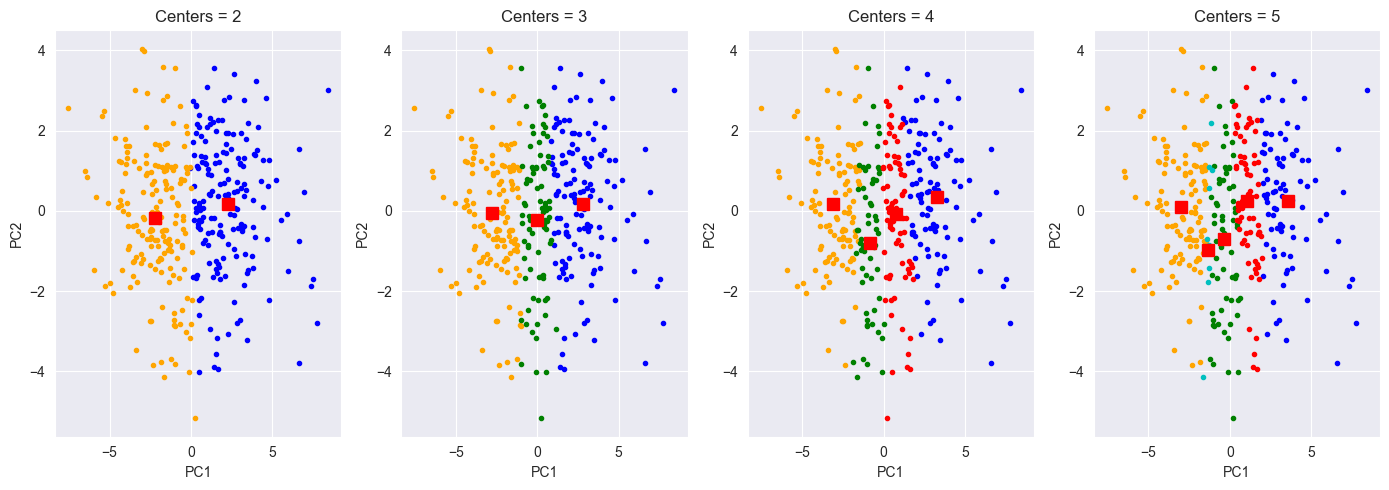

In [1237]:
# Plot data
fig, axes = plt.subplots(1, len(thresholds), figsize=(14, 5))

# Take min ncenters
min_ncenters = np.asarray([len(init_partition[t][0]) for t in thresholds]).min()

for ncenters, ax in enumerate(axes.reshape(-1), min_ncenters):

    # Plot data
    for j in range(ncenters):
        # Plot over PC1 and PC2 data such that their cluster_center == j
        ax.plot(df_pc['PC1'][info[ncenters][1] == j], df_pc['PC2'][info[ncenters][1] == j], '.', color=colors[j])

    # Compute the centers in the new space
    m = np.dot(best[ncenters][0], eigenvectors)
    # Mark the center of each fuzzy cluster
    for pt in m:
        ax.plot(pt[0], pt[1], 'rs', markersize=8)

    # Add title to the plot
    ax.set_title('Centers = {0}'.format(ncenters))
    # Add labels to the plot
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

fig.tight_layout()

As the plot below shows, it's pointless to pick the number of clusters which minimizes the cost function.

Text(0, 0.5, 'Cost Function')

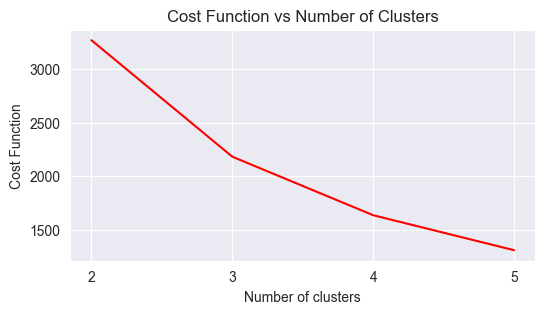

In [1238]:
# Plot the best cost function obtained for each ncenters
plt.figure(figsize=(6, 3))

# Take max ncenters
max_ncenters = np.asarray([len(init_partition[t][0]) for t in thresholds]).max()

# Add a line to connect the points
plt.plot(range(2, max_ncenters+1), [info[ncenters][2] for ncenters in range(2, max_ncenters+1)], 'r-')

# Only show integers in the x-axis
plt.xticks(range(2, max_ncenters+1))

plt.title('Cost Function vs Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Cost Function')

Compare previous values for the cost function compared to the ones obtained with IAP.

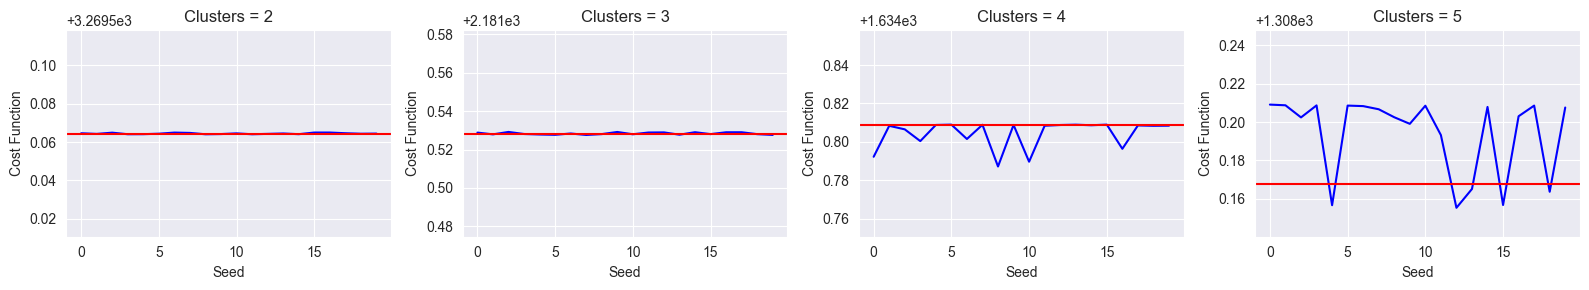

In [1239]:
# Make one plot for each value of ncenters
fig, axes = plt.subplots(1, num_clusters-1, figsize=(16, 3))

# Compute intercept range(2, num_clusters+1) and old_avg.keys()
ncenters_to_plot = set(range(2, num_clusters+1)).intersection(old_avg.keys())

for ncenters in ncenters_to_plot:

    # Plot the line
    axes[ncenters-2].plot(range(num_seeds), [old_info[ncenters, seed][2] for seed in range(num_seeds)], 'b')
    # Add constant line for info[ncenters][2]
    axes[ncenters-2].axhline(y=info[ncenters][2], color='r')
    # Add title to the plot
    axes[ncenters-2].set_title('Clusters = {0}'.format(ncenters))
    # Add labels to the plot
    axes[ncenters-2].set_xlabel('Seed')
    axes[ncenters-2].set_ylabel('Cost Function')

for ncenters in range(2, num_clusters+1):
    axes[ncenters-2].set_ylim(old_avg[ncenters]-old_diff, old_avg[ncenters]+old_diff)

fig.tight_layout()


Let's plot the membership values for each cluster...

CHECK THE TITLES OF THE PLOTS AND THEIR ORDER, I ASSIGNED MANUALLY


Text(0.5, 1.0, 'Bad team')

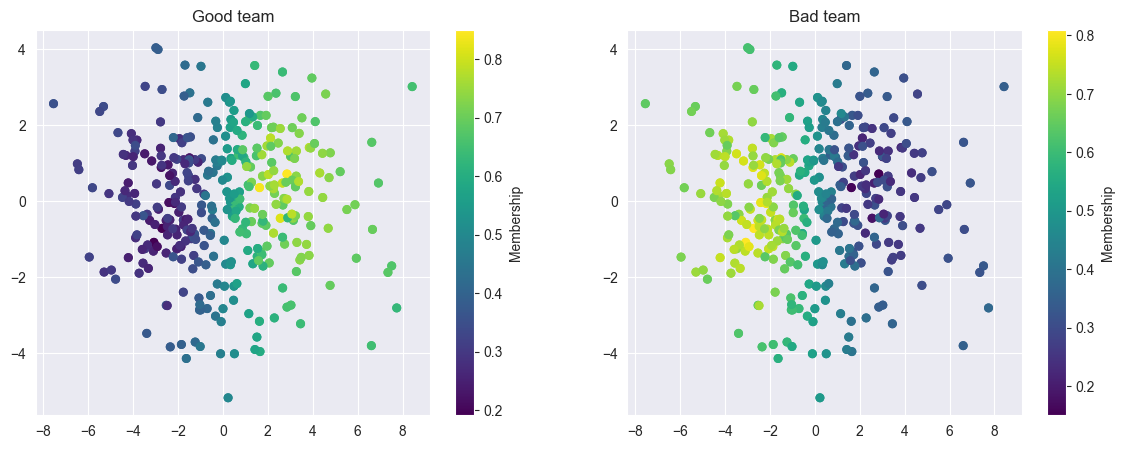

In [1240]:
# Assuming the best number of clusters is 2
n = 2

fig, axes = plt.subplots(1, n, figsize=(14, 5))
for cluster_num, ax in enumerate(axes.reshape(-1)):
    ax.scatter(df_pc['PC1'], df_pc['PC2'], c=info[n][3][cluster_num], cmap='viridis', s=30)
    # Add colorbar
    cbar = plt.colorbar(ax.scatter(df_pc['PC1'], df_pc['PC2'], c=info[n][3][cluster_num], cmap='viridis', s=30), ax=ax)
    cbar.set_label('Membership')
    ax.grid(True)

# Add titles to the first and second subplots
print("CHECK THE TITLES OF THE PLOTS AND THEIR ORDER, I ASSIGNED MANUALLY")
axes[0].set_title('Good team')
axes[1].set_title('Bad team')

CHECK THE TITLES OF THE PLOTS AND THEIR ORDER, I ASSIGNED MANUALLY


Text(0.5, 1.0, 'Average team')

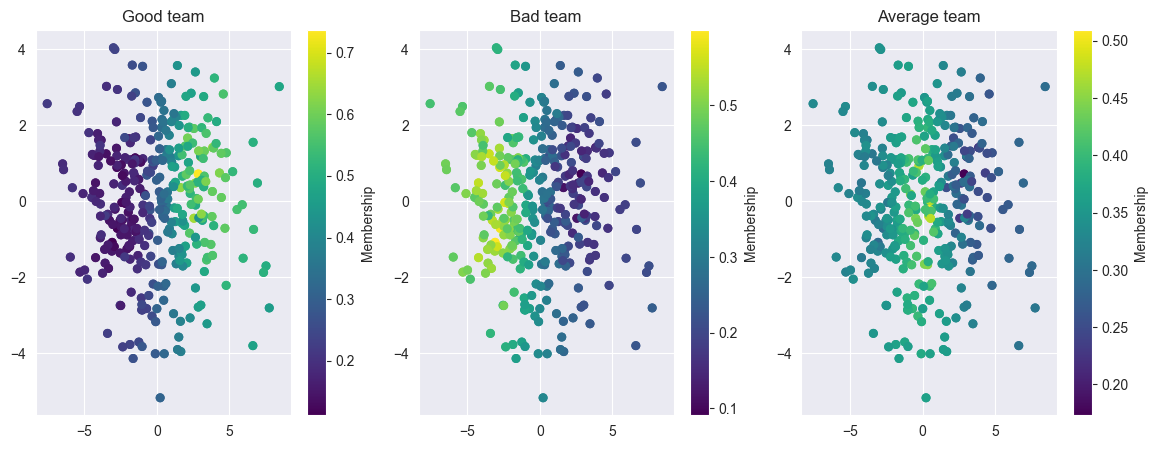

In [1241]:
# Assuming the best number of clusters is 3
n = 3

fig, axes = plt.subplots(1, n, figsize=(14, 5))
for cluster_num, ax in enumerate(axes.reshape(-1)):
    ax.scatter(df_pc['PC1'], df_pc['PC2'], c=info[n][3][cluster_num], cmap='viridis', s=30)
    # Add colorbar
    cbar = plt.colorbar(ax.scatter(df_pc['PC1'], df_pc['PC2'], c=info[n][3][cluster_num], cmap='viridis', s=30), ax=ax)
    cbar.set_label('Membership')
    ax.grid(True)

# Add titles to the first and second subplots
print("CHECK THE TITLES OF THE PLOTS AND THEIR ORDER, I ASSIGNED MANUALLY")
axes[0].set_title('Good team')
axes[1].set_title('Bad team')
axes[2].set_title('Average team')

## Exploring indeces for quality evaluation

Define functions.

In [1242]:
def pairwise_squared_distances(A, B):
    return scipy.spatial.distance.cdist(A, B)**2

def calculate_covariances(x, u, v, m):
    c, n = u.shape
    d = v.shape[1]

    um = u**m

    covariances = np.zeros((c, d, d))

    for i in range(c):
        xv = x - v[i]
        uxv = um[i, :, np.newaxis]*xv
        covariances[i] = np.einsum('ni,nj->ij', uxv, xv)/np.sum(um[i])

    return covariances

def pc(x, u, v, m):
    c, n = u.shape
    return np.square(u).sum()/n

def npc(x, u, v, m):
    c, n = u.shape
    return 1 - c/(c - 1)*(1 - pc(x, u, v, m))

def fhv(x, u, v, m):
    covariances = calculate_covariances(x, u, v, m)
    return sum(np.sqrt(np.linalg.det(cov)) for cov in covariances)

def fs(x, u, v, m):
    n = x.shape[0]
    c = v.shape[0]

    um = u**m

    v_mean = v.mean(axis=0)

    d2 = pairwise_squared_distances(x, v)

    distance_v_mean_squared = np.linalg.norm(v - v_mean, axis=1, keepdims=True)**2

    return np.sum(um.T*d2) - np.sum(um*distance_v_mean_squared)

def xb(x, u, v, m):
    n = x.shape[0]
    c = v.shape[0]

    um = u**m

    d2 = pairwise_squared_distances(x, v)
    v2 = pairwise_squared_distances(v, v)

    v2[v2 == 0.0] = np.inf

    return np.sum(um.T*d2)/(n*np.min(v2))

def bh(x, u, v, m):
    n, d = x.shape
    c = v.shape[0]

    d2 = pairwise_squared_distances(x, v)
    v2 = pairwise_squared_distances(v, v)

    v2[v2 == 0.0] = np.inf

    V = np.sum(u*d2.T, axis=1)/np.sum(u, axis=1)

    return np.sum(u**m*d2.T)/n*0.5*np.sum(np.outer(V, V)/v2)

def bws(x, u, v, m):
    n, d = x.shape
    c = v.shape[0]

    x_mean = x.mean(axis=0)

    covariances = calculate_covariances(x, u, v, m)

    sep = np.einsum("ik,ij->", u**m, np.square(v - x_mean))
    comp = sum(np.trace(covariance) for covariance in covariances)

    return sep/comp

methods = [pc, npc, fhv, fs, xb, bh, bws]
targets = "max max min min min min max".split()

Compute indeces for Fuzzy Clustering with random inizialization and for AP-FCM.

In [1243]:
results1 = []
results2 = []

# cluster data for different number of clusters
cs = list(ncenters_to_plot)
for c in ncenters_to_plot:
    # calculate cluster validity indices
    results1.append([])
    results2.append([])
    for method in methods:
        results1[-1].append(method(alldata, old_best[c][3], old_best[c][0], fuzzyness))
        results2[-1].append(method(alldata, info[c][3], info[c][0], fuzzyness))

results1 = np.array(results1)
results2 = np.array(results2)

Plot indeces for FCM.

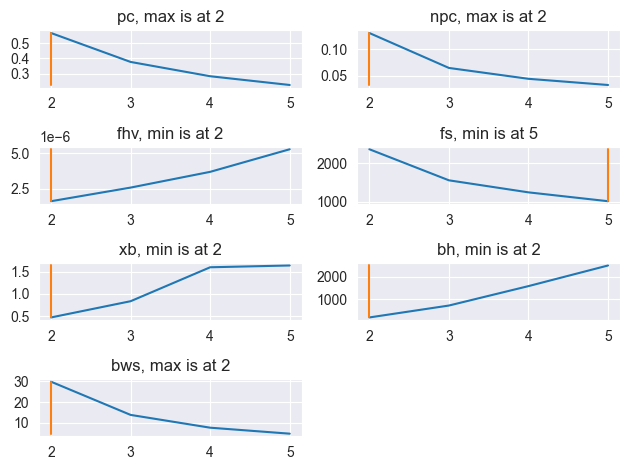

In [1244]:
# ny and nx are the number of rows and columns of the subplot grid
ny = 4
nx = 2

# plot cluster validity indices
for i, method in enumerate(methods):
    plt.subplot(ny, nx, 1 + i)
    column = results1[:, i]
    plt.plot(cs, column)

    # find best cluster size for cluster validity index
    if targets[i] == "min":
        c = cs[np.argmin(column)]
    else:
        c = cs[np.argmax(column)]
    
    plt.title("%s, %s is at %d"%(method.__name__, targets[i], c))
    
    plt.plot([c, c], [np.min(column), np.max(column)])

plt.tight_layout()

Plot indeces for AP-FCM.

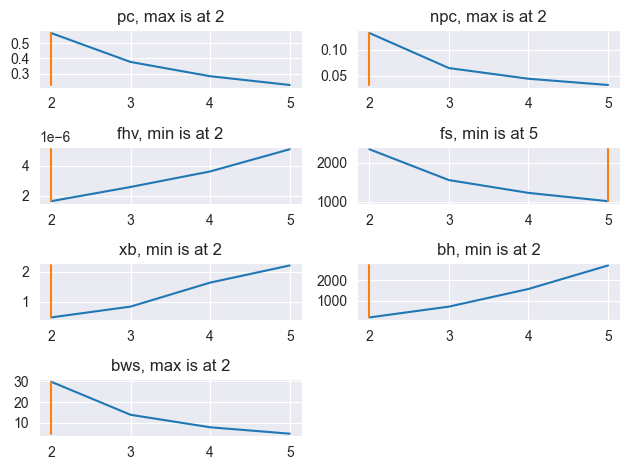

In [1245]:
# ny and nx are the number of rows and columns of the subplot grid
ny = 4
nx = 2

# plot cluster validity indices
for i, method in enumerate(methods):
    plt.subplot(ny, nx, 1 + i)
    column = results2[:, i]
    plt.plot(cs, column)

    # find best cluster size for cluster validity index
    if targets[i] == "min":
        c = cs[np.argmin(column)]
    else:
        c = cs[np.argmax(column)]
    
    plt.title("%s, %s is at %d"%(method.__name__, targets[i], c))
    
    plt.plot([c, c], [np.min(column), np.max(column)])

plt.tight_layout()